# Computing the Euler characteristic and entropy from rs_fMRI data
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Euler characteristic, entropy and Betti numbers from simplicial complexes representing functional neural networks. The networks are constructed using rs-fMRI (resting-state functional magnetic resonance imaging) data.

## Importing data

**Import libraries**

In [88]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.optimize import minimize

**Import data**

Generate an average connectivity matrix from the whole human connectome dataset.

In [4]:
# Importing all matrices with Numpy
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Generate an averaged matrix
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix
averaged_matrix = MatAv/len(matrices)

In [11]:
# Import TDA background functions
%run TDA.py

# Betti numbers, Euler Characteristic and entropy

**Betti numbers**

A set of topological invariants are the Betti numbers (𝛽). Given that a simplicial complex is a high-dimensional structure, 𝛽𝑘 counts the number of k-dimensional holes in the simplicial complex. These are topological invariants that correspond, for each 𝑘≥0, to the number of linearly independent k-dimensional holes in the simplicial complex.

In [12]:
# Compute a sparser graph (10% density)
G_d10 = densthr(0.1, averaged_matrix)
print(Betti_k(G_d10, 1))

# Compute a sparser graph (10% maximum correlation)
G_t10 = Graph_thresh(0.1, averaged_matrix)
print(Betti_k(G_t10, 1))

13
0


**Compute the Betti numbers for a given threshold/density interval**

In [10]:
# Density interval
Betti_list_d = []

for i in np.arange(0.01,0.4,0.2):
    G = densthr(i, averaged_matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list_d.append(Betti_number)

print(Betti_list_d)

[2, 0]


In [9]:
# Threshold interval
Betti_list_t = []

for i in np.arange(0.5,0.7,0.1):
    G = Graph_thresh(i, averaged_matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list_t.append(Betti_number)

print(Betti_list_t)

Check
Check
[2, 0]


**Euler Characteristic**

Another topological invariant is the Euler characteristic. From this value we can compute the Euler entropy of the network.

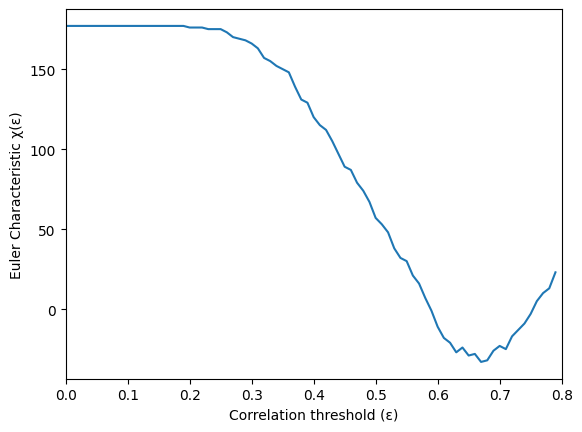

In [91]:
# Plot the Euler characteristic for a given threshold interval
i = averaged_matrix
maxvalue = 80
plt.plot(Eulerchoice_thr(i,maxvalue,0))
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler Characteristic χ(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

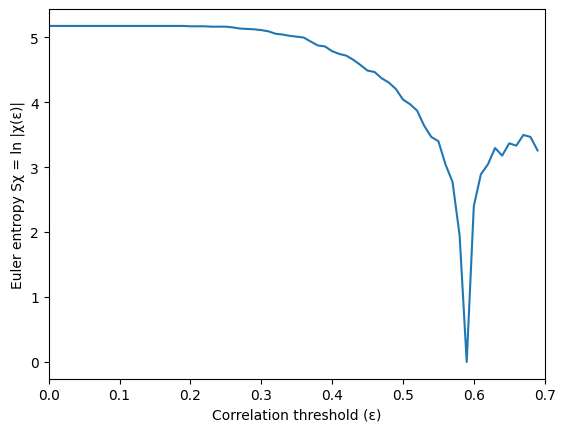

In [6]:
# Plot the Euler entropy for a given threshold interval
i = averaged_matrix
maxvalue = 70
plt.plot(np.log(np.abs(Eulerchoice_thr(i, maxvalue, 0))))
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler entropy Sχ = ln |χ(ε)|')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

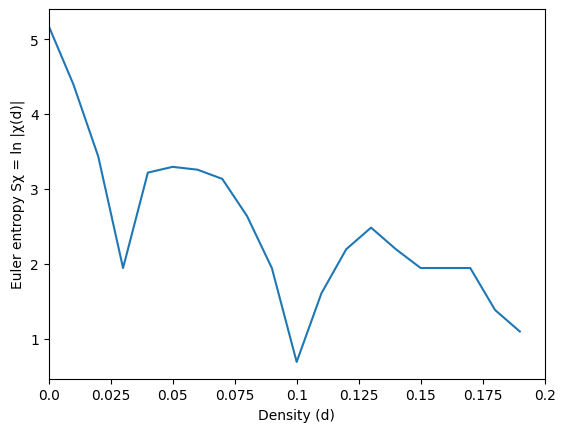

In [20]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(averaged_matrix, 20)

**Repeat entropy for individual brains and their average**

In [100]:
# Extended plot for the Euler entropy for a given threshold interval
data_size = 10 # amount of matrices
maxvalue = 60
entropy_list = []

for matrix in matrices[:data_size]:
    entropy = np.log(np.abs(Eulerchoice_thr(matrix, maxvalue, 0)))
    entropy_list.append(entropy)

average_entropy = [sum(x) / data_size for x in zip(*entropy_list)]

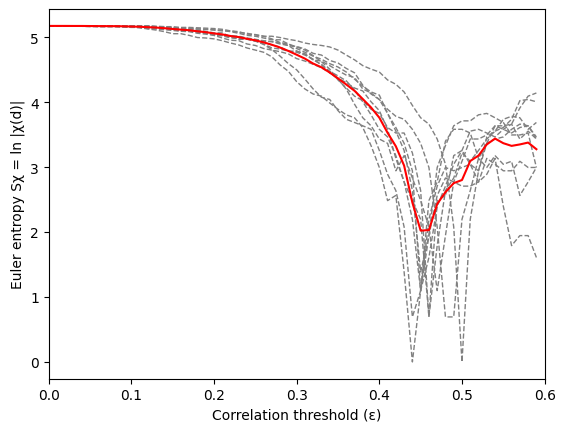

In [98]:
# Plot averaged entropy
for i in range(0, len(entropy_list)):
    plt.plot(entropy_list[i], color='grey', linestyle='--', linewidth=1)
plt.plot(average_entropy, 'r-')
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler entropy Sχ = ln |χ(ε)|')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

**Obtain the pdf with the maximum entropy**
The get the proper pdf we need to find the list of probabilities that gives the maximum entropy value. For this, a optimisation can be used like below. Compare the SPQS optimization with Simulated Annealing. SA to prevent getting stuck in local minima.

In [121]:
# Define the Shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return np.sum(probabilities * np.log(probabilities))

# Constraints for optimization
def constraint(probabilities):
    return np.sum(probabilities) - 1.0

# SLSQP optimization
def maximum_entropy(initial_probabilities):
    # Optimization setup
    cons = ({'type': 'eq', 'fun': constraint})
    bounds = [(0, 1) for _ in range(len(initial_probabilities))]
    # Perform optimization
    result = minimize(shannon_entropy, initial_probabilities, method='SLSQP', bounds=bounds, constraints=cons)
    return -result.fun

# Simulated Annealing optimization
def simulated_annealing(initial_probabilities):
    # Optimization setup
    result = minimize(shannon_entropy, initial_probabilities, method='L-BFGS-B', bounds=[(0, 1) for _ in range(len(initial_probabilities))])
    return -result.fun

In [123]:
# Example initial probabilities
list_size = 10
num_runs = 100
entropies_slsqp = []
entropies_annealing = []

for _ in range(num_runs):
    initial_probabilities = np.array(np.random.rand(list_size))

    # Maximum Entropy using SLSQP
    max_entropy_slsqp = maximum_entropy(initial_probabilities)
    entropies_slsqp.append(max_entropy_slsqp)

    # Simulated Annealing
    max_entropy_annealing = simulated_annealing(initial_probabilities)
    entropies_annealing.append(max_entropy_annealing)

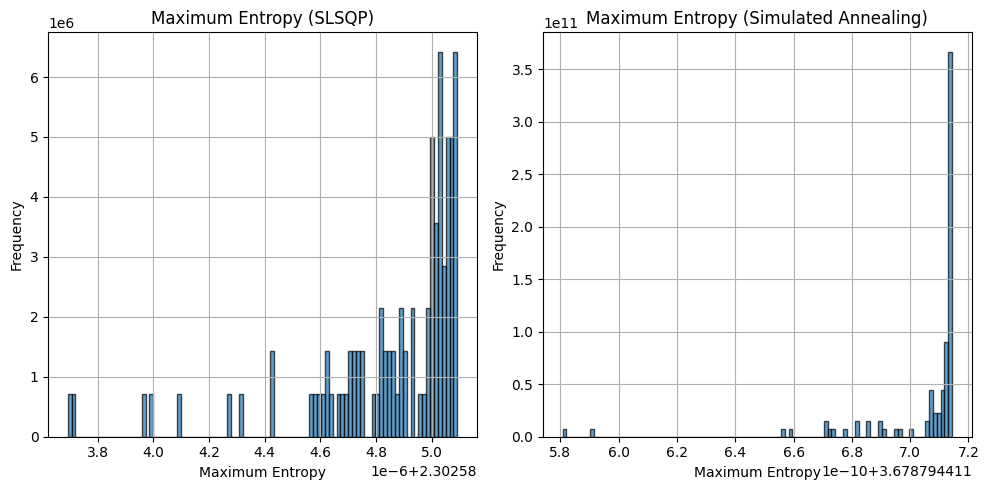

In [137]:
# Plotting the histograms side by side
plt.figure(figsize=(10, 5))

# Plotting SLSQP histogram
plt.subplot(1, 2, 1)
plt.hist(entropies_slsqp, bins=100, edgecolor='black', alpha=0.7, density=True, label='SLSQP')
plt.title('Maximum Entropy (SLSQP)')
plt.xlabel('Maximum Entropy')
plt.ylabel('Frequency')
plt.grid(True)

# Plotting Simulated Annealing histogram
plt.subplot(1, 2, 2)
plt.hist(entropies_annealing, bins=100, edgecolor='black', alpha=0.7, density=True, label='Simulated Annealing')
plt.title('Maximum Entropy (Simulated Annealing)')
plt.xlabel('Maximum Entropy')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()